In [1]:
import cv2 as cv
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from scipy.optimize import curve_fit
from pylab import mpl
from scipy.stats import mode
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import hydra
import torch
from PIL import Image

""" 
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize_config_module("segment-anything-2/sam2_configs", version_base='1.2')
device = torch.device("cuda")
#torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
checkpoint = "./sam2_hiera_base_plus.pt"
model_cfg = "sam2_hiera_b+.yaml"
SAM2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
"""

' \nhydra.core.global_hydra.GlobalHydra.instance().clear()\nhydra.initialize_config_module("segment-anything-2/sam2_configs", version_base=\'1.2\')\ndevice = torch.device("cuda")\n#torch.autocast("cuda", dtype=torch.bfloat16).__enter__()\ncheckpoint = "./sam2_hiera_base_plus.pt"\nmodel_cfg = "sam2_hiera_b+.yaml"\nSAM2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)\n'

In [2]:
def model_3d(range_dis,edge,mask,round_idx):
       global MASK_HEAD
       non_zero_index = None
       if edge is not None:
              non_zero_index = np.nonzero((range_dis!= 0.0) & (mask != 0) & (edge != 0))
       else :
              non_zero_index = np.nonzero((range_dis!= 0.0) & (mask != 0))
       final_index = np.nonzero(mask)
       represent_x = final_index[1]
       represent_y = final_index[0]
       f_X = np.vstack([represent_x, represent_y]).T
       range_dis_pred = np.zeros(range_dis.shape).astype(np.float64)
       x = non_zero_index[1]
       y = non_zero_index[0]
       z = range_dis[non_zero_index]
       X = np.vstack([x, y]).T
       #poly = PolynomialFeatures(degree=2)
       #X_ = poly.fit_transform(X)
       model = LinearRegression()
       model.fit(X, z)
       par1,par2 = model.coef_
       score = model.score(X, z)
       z_pred = model.predict(f_X)
       range_dis_pred = np.zeros_like(range_dis)
       range_dis_pred[final_index] = z_pred
       #show_range = range_dis_pred.copy()
       #show_range = show_range.astype(np.uint8)
       #cv.imwrite(f"{MASK_HEAD[:-1]}_imgs/T{idx}.jpg",show_range)
       """
       angles = [(30,100),(30,160),(10,130)]
       for elev, azim in angles:
              fig = plt.figure()
              ax = fig.add_subplot(111, projection='3d')
              ax.set_axisbelow(True)
       
              ax.scatter(x, y, z, c='r', marker='^',alpha=0.5,zorder=1)
              ax.scatter(represent_x,represent_y, z_pred, c='b', marker='o',zorder=2)
              ax.view_init(azim=100, elev=30)
              ax.set_xlabel('X Label')
              ax.set_ylabel('Y Label')
              ax.set_zlabel('Z Label')
              #print(range_dis.shape)
              
              ax.set_xlim(0,range_dis.shape[1])
              ax.set_ylim(0,range_dis.shape[0])
              ax.set_zlim(0,120)
              ax.invert_xaxis()
              ax.view_init(elev=elev, azim=azim)
              plt.legend()
              plt.show()"""
       return range_dis_pred,par1,par2,score

In [2]:
#parameters

#camera parameters
FOCAL_POINT = 20.0 #cm
TE = 100 #amount of calibration images for each distance
F = 4.0 #cm 1.6 for sony ,  4.0 for cannon
D1 = F/13.0 #cm   2.8 for sony, 13.0 for cannon
D2 = F/22.0 #cm   5.6 for sony, 22.0 for cannon
S =  (FOCAL_POINT*F)/(FOCAL_POINT-F) #cm when focus is at FOCAL_POINT cm
M2 = -((D2*S)/np.sqrt(8))
C2 = (-M2)*((1/F)-(1/S))
FRACTION = (D1/D2)**2
IMG_SIZE = (1824,1216) #(1824,1216) #for sony (2304,1536)  ,for canon (1824,1216)
SHOW_SIZE = (IMG_SIZE[0]//2,IMG_SIZE[1]//2) # for showing

#data processing parameters
SEGMENT = list()
VLP = list()  # for checking img status between different functions
BOX = list()  # for storing data to generate box graph
SMALLER = "/R"   # for smaller aperture, e.g. f/13.0
LARGER = "/L"    # for larger aperture   e.g. f/22.0
POSITION_START = 0
POSITION_END = 10
CAL_HEAD = "./datas/train/"
G_SELECT = 2 # 2 calculate larger aperture's blur, 1 for smaller aperture
NEED_SEG = False
BASE = 20   # base distance for training
PARA = 10   # distance between two training sets
PROCESS_STORAGE = CAL_HEAD[:-1]+"_process/"
BLUR_STORAGE = CAL_HEAD[:-1]+"_blur/"
BLUR_STORAGE_F = CAL_HEAD[:-1]+"_blur_f_div3/"
RESULT = "./test_fixed_pic2/" 
KER =  19 #for canon : max = 38 , middle = 19 ; for sony: max = 48 , middle = 24 , min = 12
CLAHE = cv.createCLAHE(clipLimit=2.0, tileGridSize=(64,64)) #original clipLimit=2.0, tileGridSize=(70,70)
THRESHOLD = 4000000.0  #ker = 7
#THRESHOLD =  1000000.0  # ker = 5
REC = False
REC2 = False
REC3 = False
# load images' name
def load_img():
    global R,L,MASK,MASK_HEAD

    MASK_HEAD = CAL_HEAD[:-1]+"_mask/"
    head = os.listdir(CAL_HEAD)
    head = sorted(head)
    l_place = [CAL_HEAD+i+LARGER for i in head[POSITION_START:POSITION_END]]
    r_place = [CAL_HEAD+i+SMALLER for i in head[POSITION_START:POSITION_END]]
    fileL = [sorted(os.listdir(place)) for place in l_place]
    fileR = [sorted(os.listdir(place)) for place in r_place]
    fileL = [[f for f in files if f] for files in fileL]
    fileR = [[f for f in files if f] for files in fileR]
    R = [[top+"/"+file for file in img] for img,top in  zip(fileR,r_place)]
    L = [[top+"/"+file for file in img] for img,top in  zip(fileL,l_place)]
    MASK = [np.load(f"{MASK_HEAD}T{i}.npy") for i in range((POSITION_START+1),POSITION_END+1)] if os.path.exists(MASK_HEAD) else None

load_img()
JUMPER = 0

In [3]:
# Tools 

def mouse(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        print(f"Left button clicked at ({x}, {y})")
        print(f"VLP(laplacian): {VLP[0][y,x]} VLP2(difference): {VLP[0][y,x]}")

def showing(img,cnt,flag,img_name="",floder_name=""): 
    cv.namedWindow(f"showing_{cnt}",cv.WINDOW_NORMAL)
    cv.resizeWindow(f"showing_{cnt}",SHOW_SIZE[0],SHOW_SIZE[1])
    store = None
    if flag == 1:
        show = img.copy()
        #show = cv.normalize(show, None, 0, 255, cv.NORM_MINMAX)
        cv.imshow(f"showing_{cnt}",show)
    elif flag == 2:
        show = img.copy()
        show = show.astype(np.uint8)
        #VLP.append(show.copy()) 
        #show[show > 0] = 255
        #show[np.isnan(show)] = 0

        # show = cv.cvtColor(show, cv.COLOR_GRAY2BGR)
        # show[(img <=60.0) & (img>0.0)] = [0,0,255]
        # show[img > 60.0] = [0,255,0]

        show = cv.normalize(show, None, 0, 255, cv.NORM_MINMAX)
        cv.imshow(f"showing_{cnt}",show)
        cv.setMouseCallback(f"showing_{cnt}", mouse)
        store = show
    key = cv.waitKey(0)
    if key == 27 or key == ord('q'): #ESC
        cv.destroyAllWindows()
        return False
    elif key == ord('s'): #SPACE
        if not os.path.exists(PROCESS_STORAGE):
            os.makedirs(PROCESS_STORAGE)
        if floder_name != "":
            floder_name = floder_name + "/"
            if not os.path.exists(PROCESS_STORAGE+floder_name):
                os.makedirs(PROCESS_STORAGE+floder_name)
        if flag == 1:
            cv.imwrite(f"{PROCESS_STORAGE}{floder_name}{img_name}_{cnt}.jpg",store)
        elif flag == 2:
            cv.imwrite(f"{PROCESS_STORAGE}{floder_name}{img_name}_{cnt}.jpg",store)
        cv.destroyAllWindows()
        return True
    cv.destroyAllWindows()
    return True

def showing2(img,cnt,flag):
    cv.namedWindow(f"showing1_{cnt}",cv.WINDOW_NORMAL)
    cv.namedWindow(f"showing2_{cnt}",cv.WINDOW_NORMAL)
    cv.resizeWindow(f"showing1_{cnt}",SHOW_SIZE[0],SHOW_SIZE[1])
    cv.resizeWindow(f"showing2_{cnt}",SHOW_SIZE[0],SHOW_SIZE[1])
    cv.moveWindow(f"showing1_{cnt}",0,0)
    cv.moveWindow(f"showing2_{cnt}",SHOW_SIZE[0]+100,0)
    show_res = None
    if flag == 1:
        show1 = img[0].copy()
        show2 = img[1].copy()
        show1 = cv.normalize(show1, None, 0, 255, cv.NORM_MINMAX)
        show2 = cv.normalize(show2, None, 0, 255, cv.NORM_MINMAX)
        cv.imshow(f"showing1_{cnt}",show1)
        cv.imshow(f"showing2_{cnt}",show2)
    elif flag == 2:
        show1 = img[0].copy().astype(np.uint8)*255
        show2 = cv.resize(img[1].copy(),IMG_SIZE)
        
        show1 = cv.cvtColor(show1, cv.COLOR_GRAY2BGR)
        show = cv.addWeighted(show1, 0.5, show2, 0.5, 0)
        cv.imshow(f"showing1_{cnt}",show)
        show_res = show.copy()
    key = cv.waitKey(0)
    if key == 27: #ESC
        cv.destroyAllWindows()
        return False
    elif key == ord('s'): #SPACE
        pass
    cv.destroyAllWindows()
    return show_res


def find_intersection(p1,p2,p3,p4):
    A1 = np.float64(p2[1] - p1[1])
    B1 = np.float64(p1[0] - p2[0])
    C1 = A1 * np.float64(p1[0]) + B1 * np.float64(p1[1])

    A2 = np.float64(p4[1] - p3[1])
    B2 = np.float64(p3[0] - p4[0])
    C2 = A2 * np.float64(p3[0]) + B2 * np.float64(p3[1])

    determinant = A1 * B2 - A2 * B1

    if determinant == 0:
        return None  # 平行或重合
    else:
        x = (B2 * C1 - B1 * C2) / determinant
        y = (A1 * C2 - A2 * C1) / determinant
        return int(x), int(y)
def read_cr2(file):
    with Image.open(file) as raw:
        rgb = raw.convert("RGB")
        rgb = np.array(rgb)
        bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)
        return bgr
    
def reset_txt(file):
    with open(file, 'w') as f:
        f.write('')

In [5]:
#functions

BOX.clear()
VLP.clear()
clicks = []

def mouse_callback(event, x, y, flags, param): #check the value of lp
    global VLG,clicks
    if event == cv.EVENT_LBUTTONDOWN:
        print("Y:", y," X: ",x)
        clicks.append((x, y))
        print('lg value:', VLG[y, x])
    if len(clicks) == 4:
        x_cor = [p[0] for p in clicks]
        y_cor = [p[1] for p in clicks]
        x_min,x_max = min(x_cor),max(x_cor)
        y_min,y_max = min(y_cor),max(y_cor)

        vlg_region = VLG[y_min:y_max+1,x_min:x_max+1]
        vlg_region = vlg_region[vlg_region != 0]
        mean_v = np.mean(vlg_region)
        print("VLG region : ",mean_v)
        print("Distance : ",f(mean_v,*param[0]))

        show = param[1].copy()
        show = np.array(show,dtype=np.float64)
        show = cv.normalize(show, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
        show = cv.cvtColor(show,cv.COLOR_GRAY2BGR)
        show = cv.rectangle(show,(x_min,y_min,x_max-x_min,y_max-y_min),(0,255,0),2)
        cv.imshow("cut",show)
        clicks = []

def compute(r,l,flag = 0,seg = None):
    global SEGMENT
    time_pass = 0
    if flag == 1:
        tt = cv.getTickCount()
        sa_graph = cv.cvtColor(l,cv.COLOR_BGR2RGB)
        sa_graph = cv.resize(sa_graph,IMG_SIZE,interpolation=cv.INTER_AREA)
        

        mask_generator = SAM2AutomaticMaskGenerator(SAM2,8,64,0.8,0.85,box_nms_thresh=0.8) #載入mask產生器

        masks = mask_generator.generate(sa_graph) #產生mask
        SEGMENT = masks
        print("SEGMENTATION DONE")
        time_pass = (cv.getTickCount() - tt) / cv.getTickFrequency()
        SEGMENT = sorted(SEGMENT, key=(lambda x: x['area']), reverse=True)

    # resize
    r = cv.resize(r,IMG_SIZE ,interpolation=cv.INTER_AREA)
    l = cv.resize(l,IMG_SIZE ,interpolation=cv.INTER_AREA)
    
    # r = cv.cvtColor(r,cv.COLOR_BGR2HSV_FULL)
    # l = cv.cvtColor(l,cv.COLOR_BGR2HSV_FULL)

    #brightness adjustment
    if flag == 2:
        SEGMENT = []
        unique = np.unique(seg)
        unique = unique.astype(np.uint8)
        unique = unique[unique != 0]
        for i in unique:
            one_seg = np.where(seg == i,1,0)
            one_seg = one_seg.astype(np.uint8)
            SEGMENT.append({"segmentation":one_seg,"area":np.sum(one_seg)})



    # for m in SEGMENT:
    #     r_temp = np.where(m['segmentation'] != 0,r[:,:,2],0)
    #     l_temp = np.where(m['segmentation'] != 0,l[:,:,2],0)
        
    #     brightnessR = np.mean(r_temp)
    #     brightnessL = np.mean(l_temp)

    #     alphar = brightnessR/brightnessL
    #     print("brightnessR : ",brightnessR ," brightnessL : ",brightnessL)
    #     print("brightness ration : ",alphar)
        
    #     # $ brightness adjust core

    #     l_temp = cv.convertScaleAbs(l_temp, alpha=alphar, beta=0)
        

    #     r[:,:,2] = np.where(m['segmentation'] != 0,r_temp,r[:,:,2])
    #     l[:,:,2] = np.where(m['segmentation'] != 0,l_temp,l[:,:,2])

    # r = cv.cvtColor(r,cv.COLOR_HSV2BGR_FULL)
    # l = cv.cvtColor(l,cv.COLOR_HSV2BGR_FULL)
    
    
    r = cv.cvtColor(r,cv.COLOR_BGR2GRAY)
    l = cv.cvtColor(l,cv.COLOR_BGR2GRAY)
    
    for m in SEGMENT:
        r_temp = np.where(m['segmentation'] != 0,r,0)
        l_temp = np.where(m['segmentation'] != 0,l,0)
        
        brightnessR = np.mean(r_temp)
        brightnessL = np.mean(l_temp)

        alphar = brightnessR/brightnessL
        # print("brightnessR : ",brightnessR ," brightnessL : ",brightnessL)
        # print("brightness ration : ",alphar)
        
        # $ brightness adjust core

        l_temp = cv.convertScaleAbs(l_temp, alpha=alphar, beta=0)
        

        r = np.where(m['segmentation'] != 0,r_temp,r)
        l = np.where(m['segmentation'] != 0,l_temp,l)

    # showing2([r,l],0,1)

    r = CLAHE.apply(r)
    l = CLAHE.apply(l)

    r = np.float64(r)
    l = np.float64(l)
    # gaussian and laplacian
    # vector = cv.getGaussianKernel(5,0.5)
    # kernel = vector @ vector.T
    # Gr = cv.filter2D(r,-1,kernel)
    # Gl = cv.filter2D(l,-1,kernel)
    

    k_size = 7
    scale = 2
    
    Lp = None
    if G_SELECT == 1:#result will be r's blur degree
        Lp = cv.Laplacian(l,cv.CV_64F,ksize=k_size,scale=scale)
    elif G_SELECT == 2:#result will be l's blur degree
        Lp = cv.Laplacian(r,cv.CV_64F,ksize=k_size,scale=scale)


    dif = (r-l)**2
    temp = r-l
    # if(temp.min()<0):
    #     print("HAS NEGATIVE VALUE")
    #     print(temp.min())
    #     print("==========================")
    Lp = Lp**2
    
    if flag == 1:
        return dif,Lp,time_pass
    if flag == 2:
        return dif,Lp,1
   
def sliding_window_sum(mask,target):
    # 獲取mask的形狀
    rows, cols = mask.shape
    
    # 初始化結果矩陣
    out_rows = (rows - KER) // KER + 1
    out_cols = (cols - KER) // KER + 1
    
    # 初始化結果矩陣
    result = np.zeros((out_rows, out_cols), dtype=object)
    
    # 遍歷mask
    for i in range(0, rows - KER + 1, KER):
        for j in range(0, cols - KER + 1, KER):
            # 獲取當前窗口
            window = mask[i:i + KER, j:j + KER]
            target_window = target[i:i + KER, j:j + KER]

            # 找出窗口內的所有區域
            unique_regions = np.unique(window)
            unique_regions = unique_regions[unique_regions != 0]
            unique_regions = unique_regions[~np.isnan(unique_regions)]
            # 初始化當前窗口的結果
            window_result = {}
            
            # 計算每個區域的總和
            for region in unique_regions:
                # show_mask = np.zeros_like(mask)
                # mask_temp = np.where(window == region, 1, 0)
                # show_mask[i:i + KER, j:j + KER] = mask_temp
                # show_mask = cv.cvtColor(show_mask.astype(np.uint8), cv.COLOR_GRAY2BGR)
                # show_mask *= 255
                # show_window = cv.addWeighted(cv.resize(VLP[0],IMG_SIZE), 0.5, show_mask, 0.5, 0)
                # showing(show_window,region,1)
                window_result[region] = np.nansum(target_window[window == region])
            # 儲存結果
            result[i // KER, j // KER] = window_result
            
    return result

def compute_blurness(sum_dif,sum_Lp,mask,record = False,distance_para = None):
    temp_dif = None
    temp_Lp = None
    range_dis = None
    blurness = np.zeros_like(sum_dif)
    mean = []
    if record:
        temp_dif = np.zeros_like(sum_dif)
        temp_Lp = np.zeros_like(sum_Lp)
    if distance_para is not None:
        range_dis = np.zeros_like(sum_dif)
    for m in mask:
        for i in range(len(sum_dif)):
            for j in range(len(sum_dif[0])):
                if m in sum_dif[i,j] and sum_Lp[i,j][m] != 0 and sum_Lp[i,j][m] != np.nan and sum_dif[i,j][m] != np.nan:
                    if record:
                        temp_dif[i,j] = sum_dif[i,j][m]
                        temp_Lp[i,j] = sum_Lp[i,j][m]
                    mean.append( sum_Lp[i,j][m])
                    G = np.sqrt(np.divide((16*sum_dif[i,j][m]),sum_Lp[i,j][m]))
                    parameter = ((FRACTION-1) if G_SELECT==2 else (1-(1/FRACTION)))
                    blurness[i,j] = np.sqrt(np.divide(G,parameter))
                    if distance_para is not None:
                        range_dis[i,j] = f(blurness[i,j],*distance_para)
                else:
                    blurness[i,j] = np.nan
                    if record:
                        temp_dif[i,j] = np.nan
                        temp_Lp[i,j] = np.nan
                    if distance_para is not None:
                        range_dis[i,j] = np.nan
    mean_lp = np.nanmean(mean)

    if distance_para is None:
        return blurness,temp_dif,temp_Lp
    else:
        return blurness,range_dis

def train():
    # global THRESHOLD
    distance = [BASE + PARA*i for i in range(POSITION_END)]
    real = [BASE + PARA*time for time in range(POSITION_END) for _ in range(TE) ]
    totalBlurness = []

    count = 1
    lp_seg = None
    for rs,ls,seg in zip(R,L,MASK):
        print(f"Calibrating {(count//TE)+1} group")
        seg = cv.resize(seg,IMG_SIZE)
        # print("Area : ",cv.countNonZero(seg))
        for r_name in rs:
            r = None
            if r_name.endswith(".CR2"):
                r = read_cr2(r_name)
            else:
                r = cv.imread(r_name)
            for l_name in ls:
                # read image
                l = None
                if l_name.endswith(".CR2"):
                    l = read_cr2(l_name)
                else:
                    l = cv.imread(l_name)
                # compute laplacian and difference value
                dif,Lp,_ = compute(r,l,2,seg=seg)
                #seg_show = cv.addWeighted(cv.resize(r, seg.shape[::-1]), 0.5, cv.cvtColor(seg.astype(np.uint8), cv.COLOR_GRAY2BGR)*255, 0.5, 0)
                # if np.sum(seg) <= 40000000.0:
                #     THRESHOLD = 500000.0
                # else:
                #     THRESHOLD = 3000000.0
                # print("SUM : ",np.sum(seg))
                # print("THRESHOLD : ",THRESHOLD)
                # lp_seg = np.where(Lp<=THRESHOLD,0,seg)  #edge after method

                dif = np.where(seg != 0,dif,np.nan)
                Lp = np.where(seg != 0,Lp,np.nan)
                
                #VLP.append(lp_seg.copy())
                # showing(lp_seg,count,2,img_name="mask_",floder_name="mask")
                #showing(dif,count,2)
                # print("=====================================")
                # print("Mean of difference : ",np.nanmean(dif))
                # print("=====================================")
                
                #VLP.clear()
                sum_dif = sliding_window_sum(seg,dif)
                sum_Lp = sliding_window_sum(seg,Lp)

            
                blurness = np.zeros_like(sum_dif)
                vals = np.unique(seg)
                vals = vals[vals != 0]

                blurness,temp_dif,temp_Lp = compute_blurness(sum_dif,sum_Lp,vals,record=REC)
                blurness = np.array(blurness,dtype=np.float64)

                if REC2:  # for recording convoluted blurness
                    if os.path.isdir(BLUR_STORAGE) == False:
                        os.mkdir(BLUR_STORAGE)
                    if os.path.isdir(f"{BLUR_STORAGE}T{((count-1)//TE)+1}") == False:
                        os.mkdir(f"{BLUR_STORAGE}T{((count-1)//TE)+1}")
                    np.save(f"{BLUR_STORAGE}T{((count-1)//TE)+1}/{str(count).zfill(4)}.npy",blurness)
                
                if lp_seg is not None:
                    blurness = np.repeat(np.repeat(blurness,KER,axis=0),KER,axis=1)
                    blurness[lp_seg == 0] = np.nan

                if REC3:  # for recording full size blurness
                    if os.path.isdir(BLUR_STORAGE_F) == False:
                        os.mkdir(BLUR_STORAGE_F)
                    if os.path.isdir(f"{BLUR_STORAGE_F}T{((count-1)//TE)+1}") == False:
                        os.mkdir(f"{BLUR_STORAGE_F}T{((count-1)//TE)+1}")
                    np.save(f"{BLUR_STORAGE_F}T{((count-1)//TE)+1}/{str(count).zfill(4)}.npy",blurness)

                blurness = blurness[np.isnan(blurness) == False]
                

                # $
                if temp_dif is not None:
                    # temp_Lp = np.repeat(np.repeat(temp_Lp,KER,axis=0),KER,axis=1)
                    # temp_dif = np.repeat(np.repeat(temp_dif,KER,axis=0),KER,axis=1)
                    # temp_Lp[lp_seg == 0.0] = 0.0
                    # temp_dif[lp_seg == 0.0] = 0.0
                    if os.path.isdir(CAL_HEAD[:-1]+"_detail") == False:
                        os.mkdir(CAL_HEAD[:-1]+"_detail")
                        os.mkdir(CAL_HEAD[:-1]+"_detail/lap")
                        os.mkdir(CAL_HEAD[:-1]+"_detail/dif")
                    np.save(f"{CAL_HEAD[:-1]}_detail/lap/T{count}.npy",temp_Lp)
                    np.save(f"{CAL_HEAD[:-1]}_detail/dif/T{count}.npy",temp_dif)

                # print(f"Length of blurness : {len(blurness)}")

                smooth_blurness = np.nanmean(blurness)

                #if smooth_o2>0.1:
                #    smooth_o2 = np.nan

                totalBlurness.append(smooth_blurness)
                print(f"Done {count%TE} .")
                count += 1
            #     break
            # break
    mean_of_all_blurness = dict()
    res = list()
    blurness_distance = {totalBlurness[i]:real[i] for i in range(len(totalBlurness))}
    print(blurness_distance)
    index = 0
    for _ in range(POSITION_END):
        res.append(totalBlurness[index:(index+TE)])
        index += TE


    for dist,part_blurness in zip(distance,res):
        print(part_blurness)
        blurness_temp = np.array(part_blurness,dtype=np.float64)
        mean = np.nanmean(blurness_temp)
        mean_of_all_blurness.update({mean:dist})
    
    print(mean_of_all_blurness)
    compute_model(mean_of_all_blurness,blurness_distance)

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,2)
    plt.plot(totalBlurness)
    plt.xlabel("ID")
    plt.xticks(np.arange(0,len(totalBlurness)+1,TE))
    plt.ylabel("Bluryness")
    for x in range(0,len(totalBlurness),TE):
        plt.axvline(x,color='r',linestyle='--')

    plt.title("Bluryness")
    
    for i,data in enumerate(res):
        print(f"DIS{distance[i]} : {np.std(data)}")
    
    f = open("calibrate.txt","+a")
    for i in res:
       f.write(str(np.mean(i))+"\n")
    f.write("\n")
    f.close()
    plt.show()

def f(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

def compute_model(table,table2):
    para,_ = curve_fit(f, list(table.keys()),list(table.values()))
    #models = np.poly1d(np.polyfit(list(table.keys()),list(table.values()),2))
    polyline = np.linspace(0,0.13,10000)
    plt.scatter(list(table2.keys()),list(table2.values()),color='g',label="data",alpha=0.3)
    plt.scatter(list(table.keys()),list(table.values()),color='r',label="smoothed data")
    plt.plot(polyline,f(polyline,*para),label="quadratic line")
    plt.title("Relationship between blur and distance")
    plt.xlabel("Bluryness")
    plt.ylabel("Distance (cm)")
    plt.ylim(0,150)
    #plt.xlim(0,0.13)
    plt.legend()
    plt.show()
    print(para)


def main(r_name,l_name,mask_save_num = 0,seg_mask = None,round_idx = 0,oblique = False,seg_size = None):
    global SEGMENT
    
    para = [[279794.7033, - 47791.3160 ,  2889.6554 , - 30.6857 ]]
    r,l = None,None
    #read image
    if r_name.endswith(".CR2"):
        r = read_cr2(r_name)
    else:
        r = cv.imread(r_name)
    if l_name.endswith(".CR2"):
        l = read_cr2(l_name)
    else:
        l = cv.imread(l_name)
    #adjust segmentation mask range
    if seg_size != None:
        print(np.unique(seg_mask))
        seg_temp = np.where(seg_mask != 1,seg_mask,0)
        seg_mask = np.where(seg_mask == 1,seg_mask,0)
        seg_mask = seg_mask.astype(np.uint8)

        current_area = cv.countNonZero(seg_mask)
        if current_area > 0:
            ksize = int(np.sqrt(current_area*abs(seg_size)))
            print("current ksize : ",ksize)
            if ksize < 3:
                ksize = 3
            if ksize % 2 == 0:
                ksize += 1
            kernel = np.ones((ksize,ksize),np.uint8)

            if(seg_size >0):
                seg_mask = cv.dilate(seg_mask,kernel,iterations=1)
            elif(seg_size<0):
                seg_mask = cv.erode(seg_mask,kernel,iterations=1)
                
        seg_mask = np.where(seg_mask != 1,seg_temp,seg_mask)
        # img_w = showing2([seg_mask,l],0,2) 
        # if os.path.isdir(RESULT) == False:
        #     os.mkdir(RESULT)
        # if os.path.isdir(f"{RESULT}T{round_idx}") == False:
        #     os.mkdir(f"{RESULT}T{round_idx}")
        # cv.imwrite(f"{RESULT}T{round_idx}/{seg_size}.jpg",img_w)


    tt = cv.getTickCount()
    dif,Lp,seg_time = compute(r,l,flag=(2 if mask_save_num == 0 else 1),seg=seg_mask)
    other_time = ((cv.getTickCount() - tt) / cv.getTickFrequency()) - seg_time
    print("Segmetation cost: ",seg_time," sec")

    final_distance = np.zeros_like(dif)
    used = np.zeros_like(dif).astype(bool)
    
    count = 1
    real_distance = [[25.0],
                     [56.0],
                     [103.0],
                     [33.0],
                     [64.0],
                     [97.0],
                     [41.0],
                     [73.0],
                     [88.0]
                     ]
    np_save = np.zeros_like(dif)
    
    masks = np.zeros_like(dif).astype(np.uint8)
    size_of_mask = list()
    
    for mask in SEGMENT:
        
        tt = cv.getTickCount()
        window_size = mask['segmentation']
        window_size = window_size.astype(np.uint8)
        opening_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
        window_size = cv.morphologyEx(window_size, cv.MORPH_OPEN, opening_kernel,iterations=2).astype(bool)
        dif_shape = dif.shape
        window_shape = window_size.shape
        repeat_y = dif_shape[0] // window_shape[0]
        repeat_x = dif_shape[1] // window_shape[1]
        window_size = np.repeat(np.repeat(window_size,repeat_y,axis=0),repeat_x,axis=1) #expand window_size to the same size of dif

        if mask_save_num != 0:
            print(f"Area of {mask_save_num} : ",mask['area'])
            box = mask['bbox']
            l_temp = cv.resize(l,IMG_SIZE)
            l_temp[window_size] = [0,0,0]
            #l_temp = cv.rectangle(l_temp,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(0,255,0),2)
            cv.namedWindow("cut",cv.WINDOW_NORMAL)
            cv.resizeWindow("cut", 1440,720)
            cv.imshow("cut",l_temp)

            button = cv.waitKey(0)
            if button == ord('s'):
                np_save[window_size] = count#real_distance[mask_save_num-1][count-1]
                print("SAVE DONE")
                count += 1
            elif button == ord('q'):
                cv.destroyAllWindows()
                break
            cv.destroyAllWindows()
            continue
        if np.all(np.logical_xor(np.logical_and(window_size,used),window_size) == False): #check if the window is already used
            continue
        size_of_mask.append(mask['area'])
        masks[window_size] = count
        count +=1
        used[window_size] = True
        
    
    # save mask
    if np_save.max() != 0: 
        if os.path.isdir(MASK_HEAD) == False:
            os.mkdir(MASK_HEAD)
        np.save(f'{MASK_HEAD}T{mask_save_num}.npy',np_save)
        return
    
    other_time += ((cv.getTickCount() - tt) / cv.getTickFrequency())

    #integrate with laplacian value > x 
    #edge_of_img = None
    edge_of_img = np.where(Lp<THRESHOLD,0,masks)

    uni_mask = np.unique(masks)
    uni_mask = uni_mask[uni_mask!=0]
    sum_dif = sliding_window_sum(masks,dif)
    sum_Lp = sliding_window_sum(masks,Lp)
    current_para = para[0]
    
    for m in uni_mask:

        tt = cv.getTickCount()
        pos = np.where(masks==m)
        pos = np.array(pos)

        #one_mask = np.zeros_like(masks)
        #one_mask[pos[0],pos[1]] = 1
    
        blurness,range_dis = compute_blurness(sum_dif,sum_Lp,[m],record=False,distance_para=current_para)
                
        if oblique and range_dis.max() != 0.0:

            range_dis[(range_dis <= 0.0)] = 0.0  # original <0 is 0
            range_dis[(range_dis >= 120.0)] = 120.0 # original >= 120 is 120
            resize_dis = np.repeat(np.repeat(range_dis,KER,axis=0),KER,axis=1)
            #print(f"Distance : {resize_dis[right_bottom[0][1],right_bottom[0][0]]} {resize_dis[left_bottom[0][1],left_bottom[0][0]]} {resize_dis[right_top[0][1],right_top[0][0]]} {resize_dis[left_top[0][1],left_top[0][0]]} {resize_dis[center[1],center[0]]}")
            show,x_coe,y_coe,score= model_3d(resize_dis,edge_of_img,one_mask,round_idx)
            print(f"ROUND {round_idx} : {x_coe} , {y_coe} , {score}")
            show[(show<0.0)] = 0.0
            #result = np.zeros_like(masks).astype(np.float64)
            #for i in range(len(pos[0])):
            #    result[pos[0][i],pos[1][i]] = show[int(pos[0][i]/KER),int(pos[1][i]/KER)]
            #if os.path.isdir(MASK_HEAD[:-1]+"_imgs/") == False:
            #    os.mkdir(MASK_HEAD[:-1]+"_imgs/")
            
            result = show.copy()

            #precision 
            temp_mask = one_mask.astype(np.uint8)
            temp_mask = cv.dilate(temp_mask, np.ones((3,3),np.uint8), iterations = 2)
            temp_mask = cv.erode(temp_mask, np.ones((3,3),np.uint8), iterations = 2)
            corner,_ = cv.findContours(temp_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            right_top = max(corner[0], key=lambda x: x[0][0] - x[0][1])
            right_bottom = max(corner[0], key=lambda x: x[0][0] + x[0][1])
            left_top = min(corner[0], key=lambda x: x[0][0] + x[0][1])
            left_bottom = min(corner[0], key=lambda x: x[0][0] - x[0][1])
            center = find_intersection(right_top[0],left_bottom[0],right_bottom[0],left_top[0])
            #precision
            if os.path.isdir(MASK_HEAD[:-1]+"_res/") == False:
                os.mkdir(MASK_HEAD[:-1]+"_res/")
            pred_dis = open(f"{MASK_HEAD[:-1]}_res/result.txt","+a")
            pred_dis.write(f"{result[right_bottom[0][1],right_bottom[0][0]]},{result[left_bottom[0][1],left_bottom[0][0]]},{result[right_top[0][1],right_top[0][0]]},{result[left_top[0][1],left_top[0][0]]},{result[center[1],center[0]]}\n")
            pred_dis.close()
            BOX.append( [result[right_bottom[0][1],right_bottom[0][0]]
                   ,result[left_bottom[0][1],left_bottom[0][0]]
                   ,result[right_top[0][1],right_top[0][0]]
                   ,result[left_top[0][1],left_top[0][0]]
                   ,result[center[1],center[0]]
                   ,x_coe,y_coe])
            return 1
        elif oblique == False and blurness.max() != 0.0:
            temp_edge = np.where(edge_of_img == m,1,0)
            blurness = np.repeat(np.repeat(blurness,KER,axis=0),KER,axis=1)
            #showing(blurness,mask_save_num,1)
            blurness[temp_edge == 0] = np.nan
            blurness = np.array(blurness,dtype=np.float64)
            final_blurness = np.nanmean(blurness[~np.isnan(blurness)])
            estimate_distance = f(final_blurness,*current_para)

            other_time += ((cv.getTickCount() - tt) / cv.getTickFrequency())
            # final_distance[pos[0],pos[1]] = estimate_distance #! origianl
            final_distance[masks == m] = estimate_distance      #! test method

            print(f"Distance : {estimate_distance} , {final_blurness} , {m}")

    print("ALL DONE")
    print("Time cost: ",other_time," sec")
    
    #error file
    if round_idx !=0:
        if os.path.isdir(RESULT) == False:
            os.mkdir(RESULT)
        if os.path.isdir(RESULT + f"T{round_idx}") == False:
            os.mkdir(RESULT + f"T{round_idx}")
        error_file = open(f"{RESULT}T{round_idx}/{seg_size}.txt","+a")

    if mask_save_num == 0:
        
        error_file.write(f"{seg_time}\t{other_time}")
        unique_val = sorted(np.unique(seg_mask))
        error_rates = list()
        for val in unique_val:
            if val == 0:
                continue
            m1 =  np.where((seg_mask == val),True,False)
            m2 = np.where((final_distance>0),True,False)
            sub_mask = np.logical_and(m1,m2)
            position = np.where(sub_mask==True)
            dis_temp = final_distance[position]
            error_rate = (np.mean(dis_temp) - val)/val
            
            error_file.write(f"\t{np.mean(dis_temp)}")
            print(error_rate," ",val," Mean",np.mean(dis_temp))

            error_rate = np.abs(error_rate)
            error_rates.append(error_rate)

        mean = np.mean(error_rates)
        print("Error Rate:",mean)
        error_file.write(f"\n")
        error_file.close()    

In [5]:
#function's parameter

"""
    # 1440,cur,alig  : 6.36518398e+06,1.36015546e+03  2min
    # 1440,cur,Nalig : 6.56829601e+06,7.45463573e+02  2min 
    # orig,cur,alig  : 2.93425007e-13,2.36794908e+04  6min
    # orig,cur,Nalig : 
    # new 1440,cur,alig  : 5.59739692e+06,2.88339626e+03
    # new 1440,cur,Nalig : 4770144.4960349,6715.89521045
    # new orig,cur,alig  : 
    # new orig,cur,Nalig : 
    # F 1440,cur,Nalig : 
    # 1440,BA,bin=2,8 : 9.38225603e+06 ,-1.12173553e+03 bad
    # 1440,BA,bin=1,8 : 7.42737095e+06 ,2.64318991e+03  
    # 1440,BA,without : 6.28836099e+06 , 4.32034447e+03 
    # 1440,BA,alig,without : 3227538.72151591  , 11250.29049538 bad
    # 1440,BA,bin=1,16,sameB : 7.20508296e+06 , 3.39826978e+03  good
    # 1440,BA,bin=1,16,sameB,change2G2 : 1.90763564e+07,-7.74046339e+03
    # busback : [ 4.45317567e+08 , -4.10884983e+05]
    # busFront: [ 6.76681740e+08 , -7.69089375e+05]
    # raw : 1.90275457e+07 , -1.76925021e+04
    # new raw : 24958794.74290193  , -28037.3159782
    # new raw 24 kernel : 26076444.1181337  , -29585.93506573
    # new raw 12 kernel : 26942840.95145722 , -30469.76259743

    # f13-22 38: 8.08876043e+06 , -3.81010186e+03 

    # f13-22 edge 38: 1.16188287e+07 , -6.32444578e+03


    # f13-22 38 +c : 1.59381548e+07 -4.46194185e+04  4.74741697e+01
    # f13-22 edge 38 +c : 2.46607410e+07 ,-6.40322782e+04 , 5.70092352e+01

    # f13-22 38 ~70 edge : 6490050.43625072  , 12378.14021616

    # f13-22 38 ~70  : 2817638.98188516 ,  10063.17260045

    # excel 20 f13-22 : 6527018650.57422,-29059478.74385,46254.76969
    # excel 30 f13-22 : 11610872713.3071,-43597582.5243,68177.0888
    
    # before 5/9 : [221933.1829,- 33764.5314,1991.1018,- 13.7335  ]
    # after 5/9 : [336410.9945,- 64795.6171,4683.8696,- 90.9330] 

    # new clahe 5/17 : [279794.7033, - 47791.3160 ,  2889.6554 , - 30.6857 ] 
    """

'\n    # 1440,cur,alig  : 6.36518398e+06,1.36015546e+03  2min\n    # 1440,cur,Nalig : 6.56829601e+06,7.45463573e+02  2min \n    # orig,cur,alig  : 2.93425007e-13,2.36794908e+04  6min\n    # orig,cur,Nalig : \n    # new 1440,cur,alig  : 5.59739692e+06,2.88339626e+03\n    # new 1440,cur,Nalig : 4770144.4960349,6715.89521045\n    # new orig,cur,alig  : \n    # new orig,cur,Nalig : \n    # F 1440,cur,Nalig : \n    # 1440,BA,bin=2,8 : 9.38225603e+06 ,-1.12173553e+03 bad\n    # 1440,BA,bin=1,8 : 7.42737095e+06 ,2.64318991e+03  \n    # 1440,BA,without : 6.28836099e+06 , 4.32034447e+03 \n    # 1440,BA,alig,without : 3227538.72151591  , 11250.29049538 bad\n    # 1440,BA,bin=1,16,sameB : 7.20508296e+06 , 3.39826978e+03  good\n    # 1440,BA,bin=1,16,sameB,change2G2 : 1.90763564e+07,-7.74046339e+03\n    # busback : [ 4.45317567e+08 , -4.10884983e+05]\n    # busFront: [ 6.76681740e+08 , -7.69089375e+05]\n    # raw : 1.90275457e+07 , -1.76925021e+04\n    # new raw : 24958794.74290193  , -28037.31597

Calibrating 1 group


Done 1 .
Done 2 .
Done 3 .
Done 4 .
Done 5 .
Done 6 .
Done 7 .
Done 8 .
Done 9 .
Done 10 .
Done 11 .
Done 12 .
Done 13 .
Done 14 .
Done 15 .
Done 16 .
Done 17 .
Done 18 .
Done 19 .
Done 20 .
Done 21 .
Done 22 .
Done 23 .
Done 24 .
Done 25 .
Done 26 .
Done 27 .
Done 28 .
Done 29 .
Done 30 .
Done 31 .
Done 32 .
Done 33 .
Done 34 .
Done 35 .
Done 36 .
Done 37 .
Done 38 .
Done 39 .
Done 40 .
Done 41 .
Done 42 .
Done 43 .
Done 44 .
Done 45 .
Done 46 .
Done 47 .
Done 48 .
Done 49 .
Done 50 .
Done 51 .
Done 52 .
Done 53 .
Done 54 .
Done 55 .
Done 56 .
Done 57 .
Done 58 .
Done 59 .
Done 60 .
Done 61 .
Done 62 .
Done 63 .
Done 64 .
Done 65 .
Done 66 .
Done 67 .
Done 68 .
Done 69 .
Done 70 .
Done 71 .
Done 72 .
Done 73 .
Done 74 .
Done 75 .
Done 76 .
Done 77 .
Done 78 .
Done 79 .
Done 80 .
Done 81 .
Done 82 .
Done 83 .
Done 84 .
Done 85 .
Done 86 .
Done 87 .
Done 88 .
Done 89 .
Done 90 .
Done 91 .
Done 92 .
Done 93 .
Done 94 .
Done 95 .
Done 96 .
Done 97 .
Done 98 .
Done 99 .
Done 0 .
Calibratin

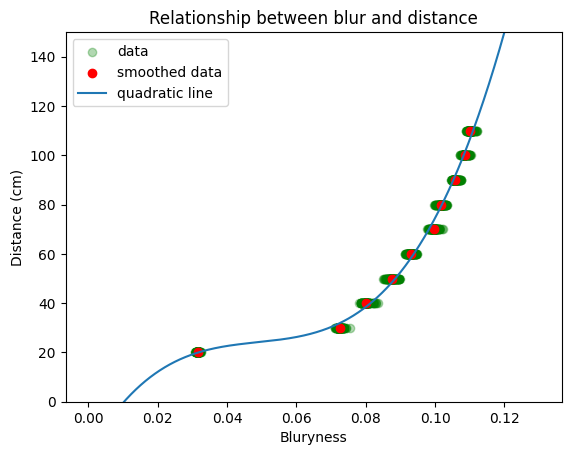

[ 3.21041356e+05 -4.71191496e+04  2.45380301e+03 -2.06900205e+01]
DIS20 : 0.00035577853287482094
DIS30 : 0.0007616112362505802
DIS40 : 0.0010401856963253246
DIS50 : 0.001167522582429574
DIS60 : 0.0008770849134403901
DIS70 : 0.0009022110258614919
DIS80 : 0.0008542466113084052
DIS90 : 0.0007215020254109319
DIS100 : 0.0006861642109007666
DIS110 : 0.0007013456400845262


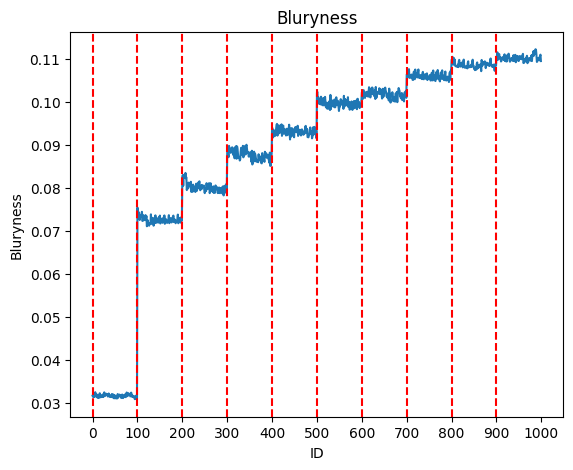

In [6]:
def path_tracker():
    compute()
    showing()
    sliding_window_sum()
    load_img()
    REC 
    JUMPER

def reset_result_file():
    for i in range(POSITION_START+1,POSITION_END+1):
        reset_txt(f"{RESULT}T{i}/-0.01.txt")

def get_shape():
    for i,imgs in enumerate(zip(R,L)):
        r = imgs[0]
        l = imgs[1]
        main(r[0],l[0],(POSITION_START+i+1))

def exp(size = 0):
    flag = 0  
    for i,data in enumerate(zip(R,L,MASK)):
        count = 0
        imagesR = data[0]
        imagesL = data[1]
        round_idx = POSITION_START+i+1
        times = len(imagesR)
        for g1 in imagesR:
            for g2 in imagesL:

                print("R = ",((count//times)+1)," L = ",((count%times)+1))
                flag  = main(g1,g2,0,data[2],round_idx,oblique=False,seg_size = size)
                count += 1
                # break
            # break
        if flag == -1: 
            break

def wrong_seg():
    for scalar in range(-2,3):
        # if scalar == 0:
        #     continue
        print("==----------------------------------------------==")
        print("SET : ",scalar)
        exp(scalar*1e-2)
        print("==----------------------------------------------==\n")

REC = False
REC2 = True     #convoluted blurness
REC3 = False    # #full size blurness

# CAL_HEAD = "./train/"
# POSITION_START = 12
# POSITION_END = 10
# load_img()


# get_shape()
train()
#reset_result_file()
# exp()
#wrong_seg()



In [7]:
BLUR_STORAGE2 = CAL_HEAD[:-1]+"_w_blur/"
BLUR_STORAGE3 = CAL_HEAD[:-1]+"_o_blur/"

blur = [np.load(f"{BLUR_STORAGE}T{((i-1)//TE)+1}/{str(i).zfill(4)}.npy") for i in range(1,POSITION_END*TE+1)]
# blur_f = [np.load(f"{BLUR_STORAGE_F}T{((i-1)//TE)+1}/{str(i).zfill(4)}.npy") for i in range(1,POSITION_END*TE+1)]

# print(BLUR_STORAGE2)
blur2 = [np.load(f"{BLUR_STORAGE2}T{((i-1)//25)+1}/{str(i).zfill(4)}.npy") for i in range(1,POSITION_END*25+1)]
blur3 = [np.load(f"{BLUR_STORAGE3}T{((i-1)//25)+1}/{str(i).zfill(4)}.npy") for i in range(1,POSITION_END*25+1)]

/tmp/ipykernel_320918/3816078387.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


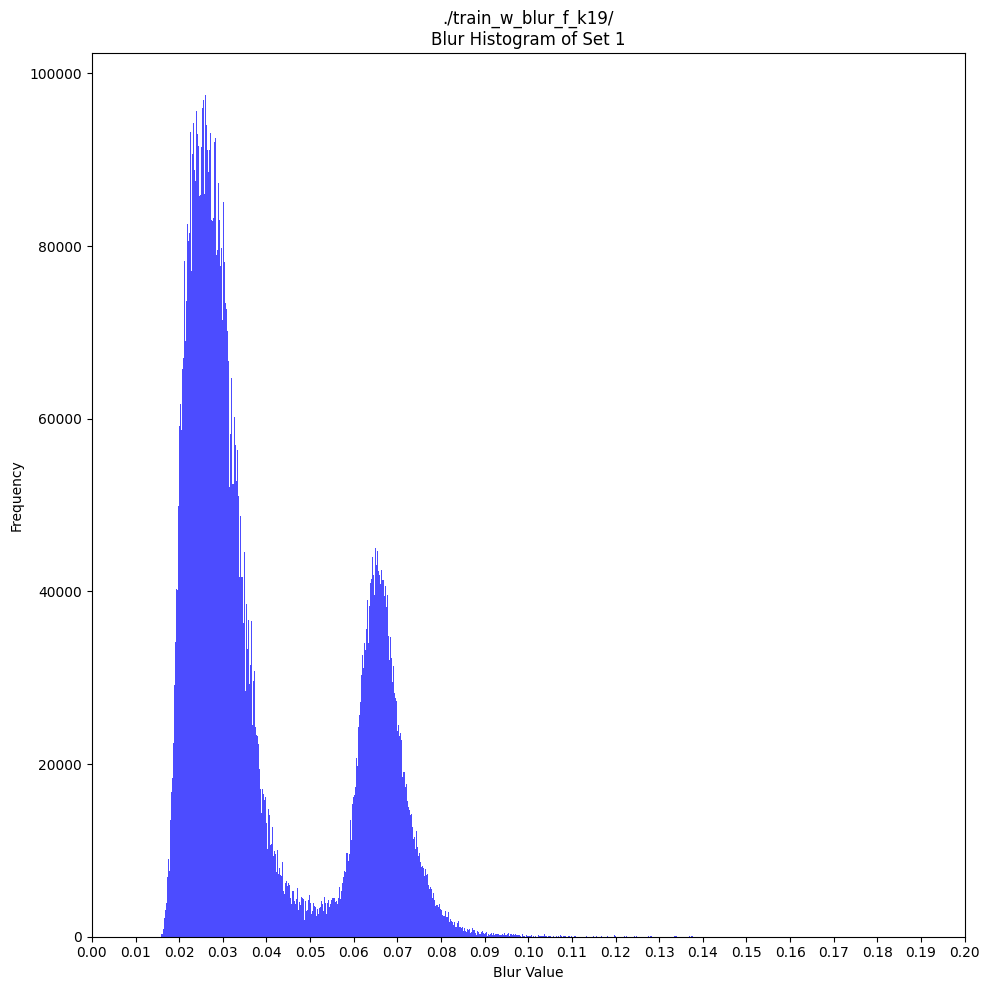

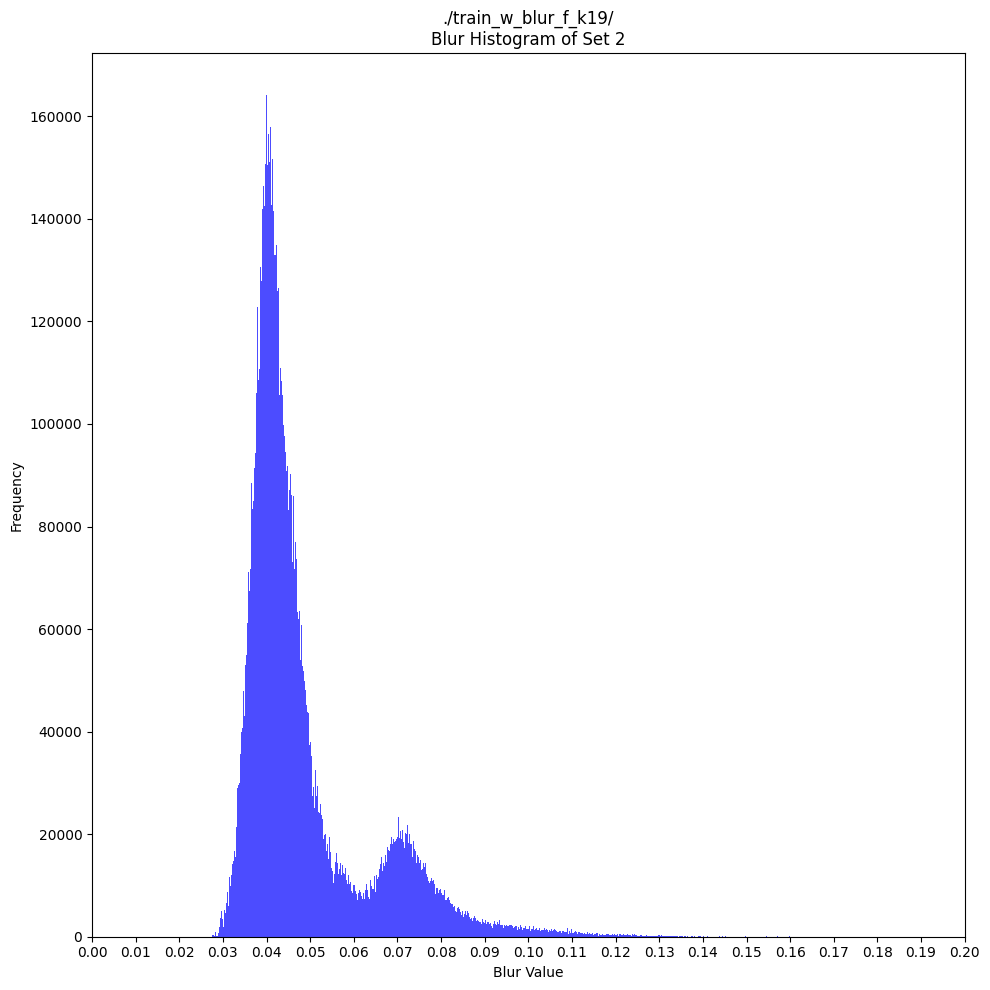

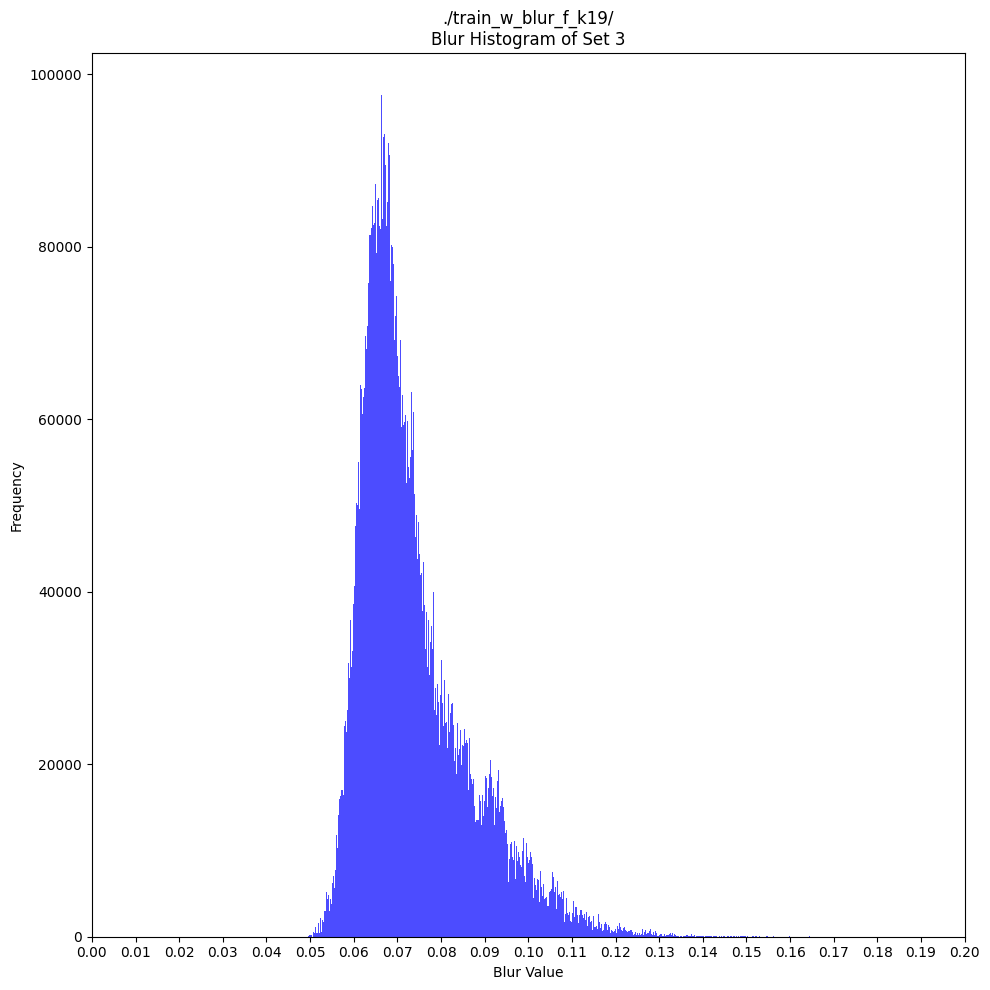

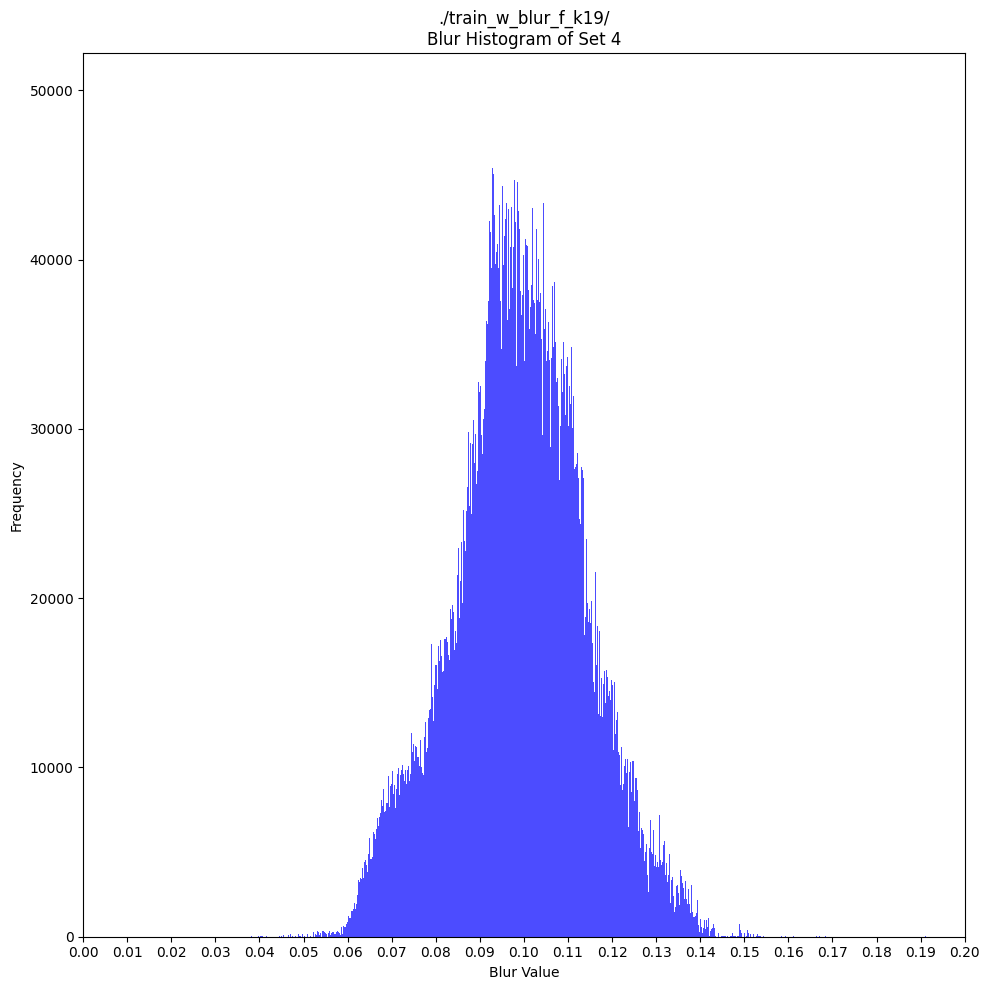

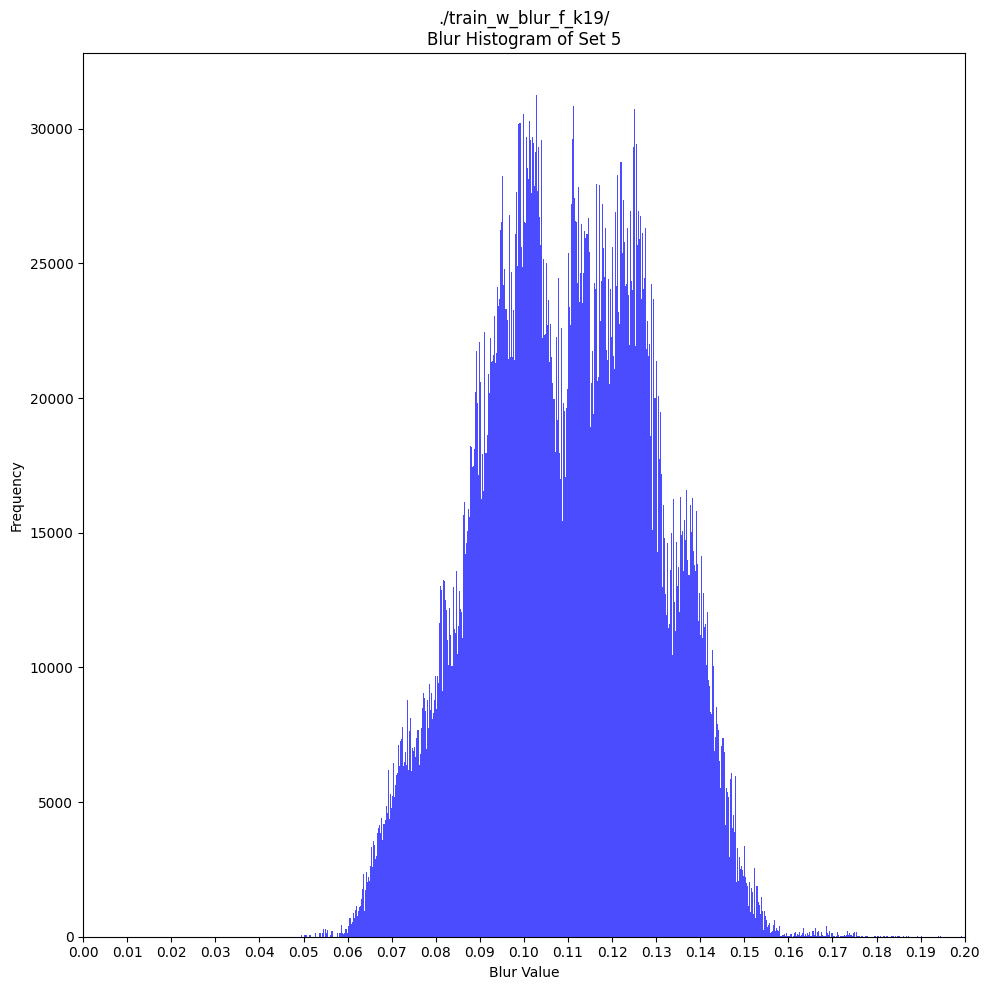

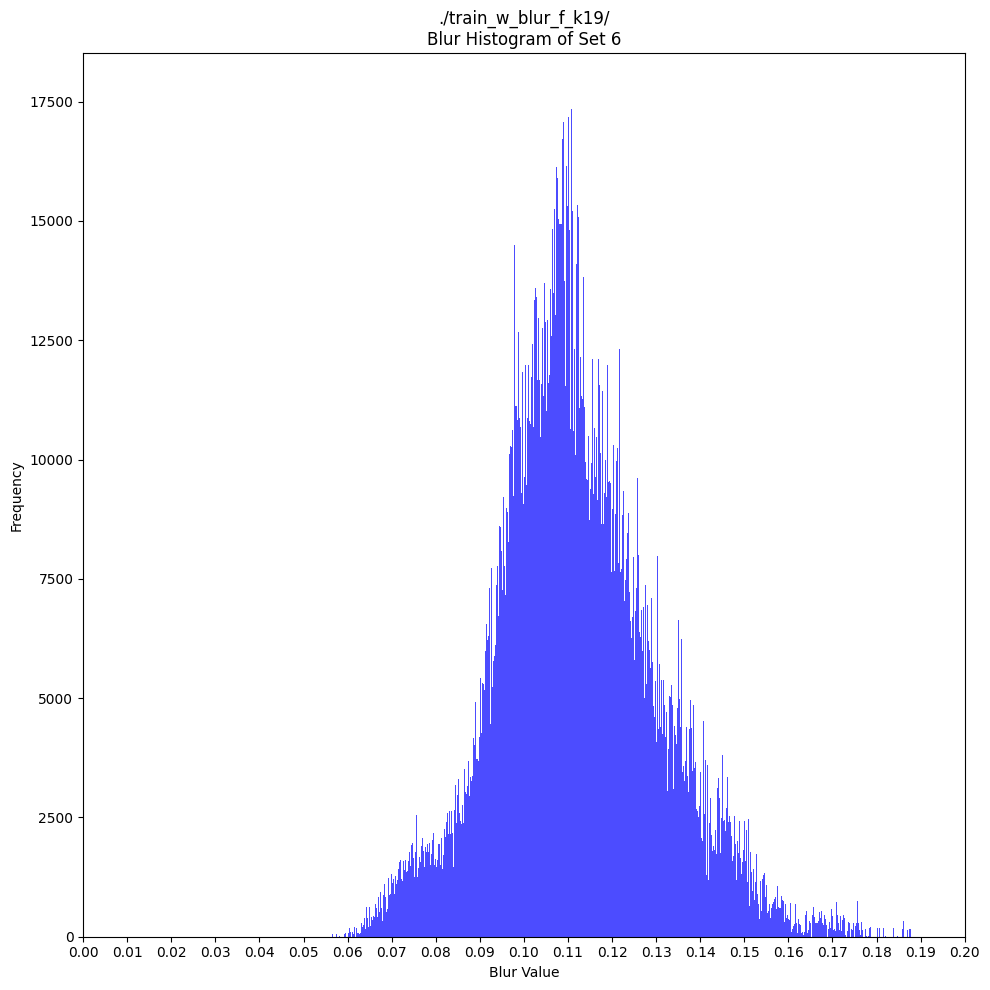

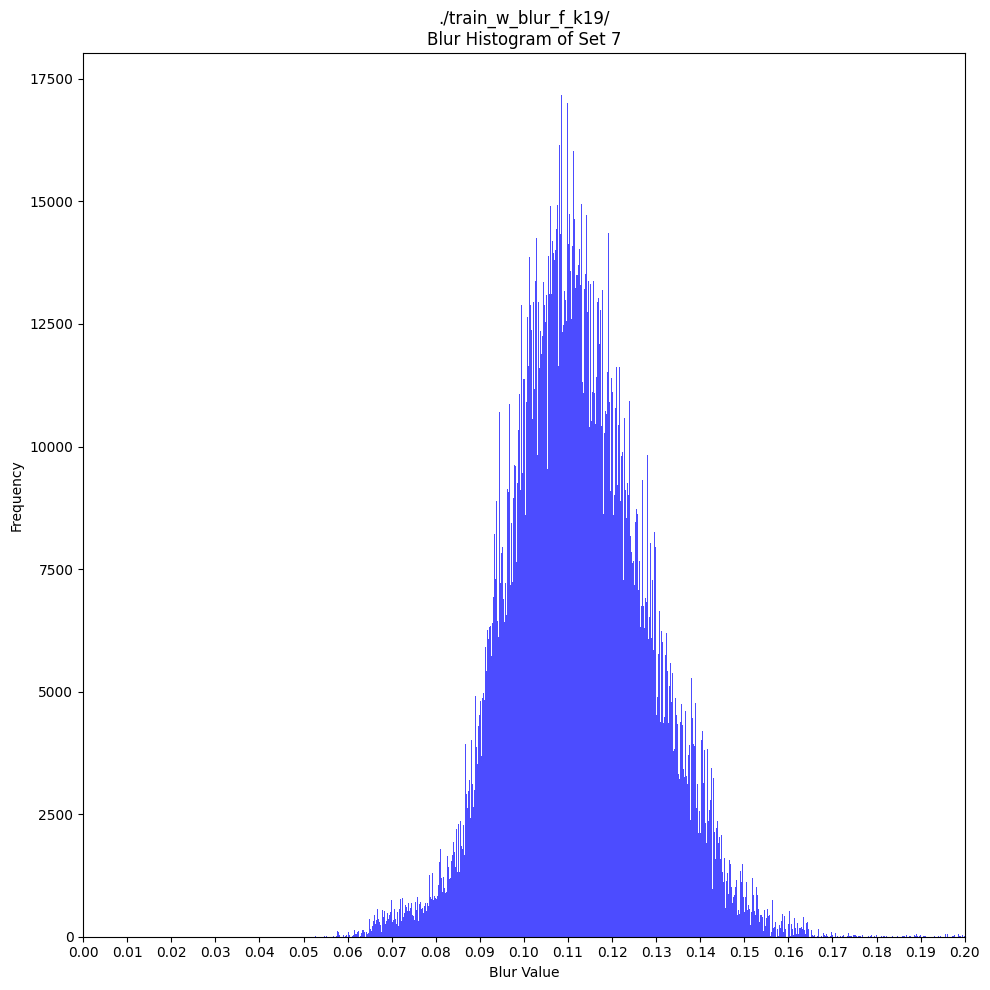

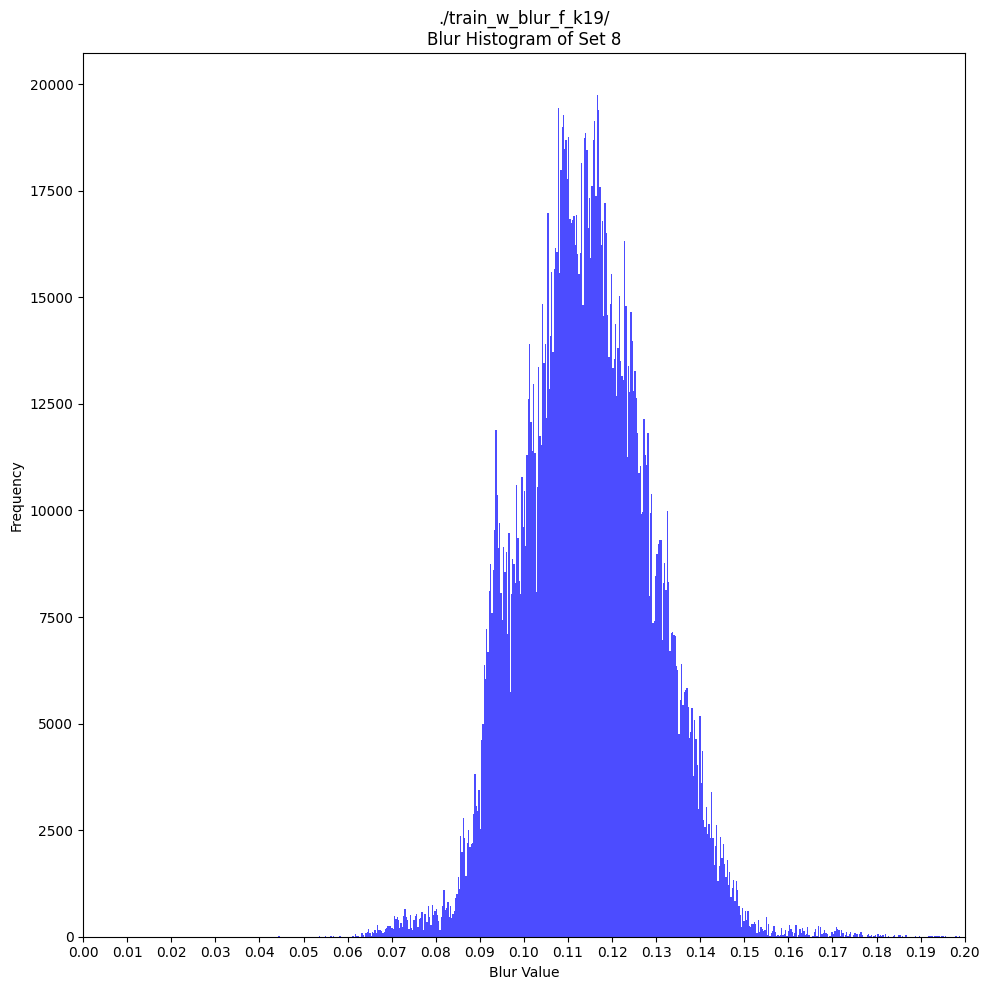

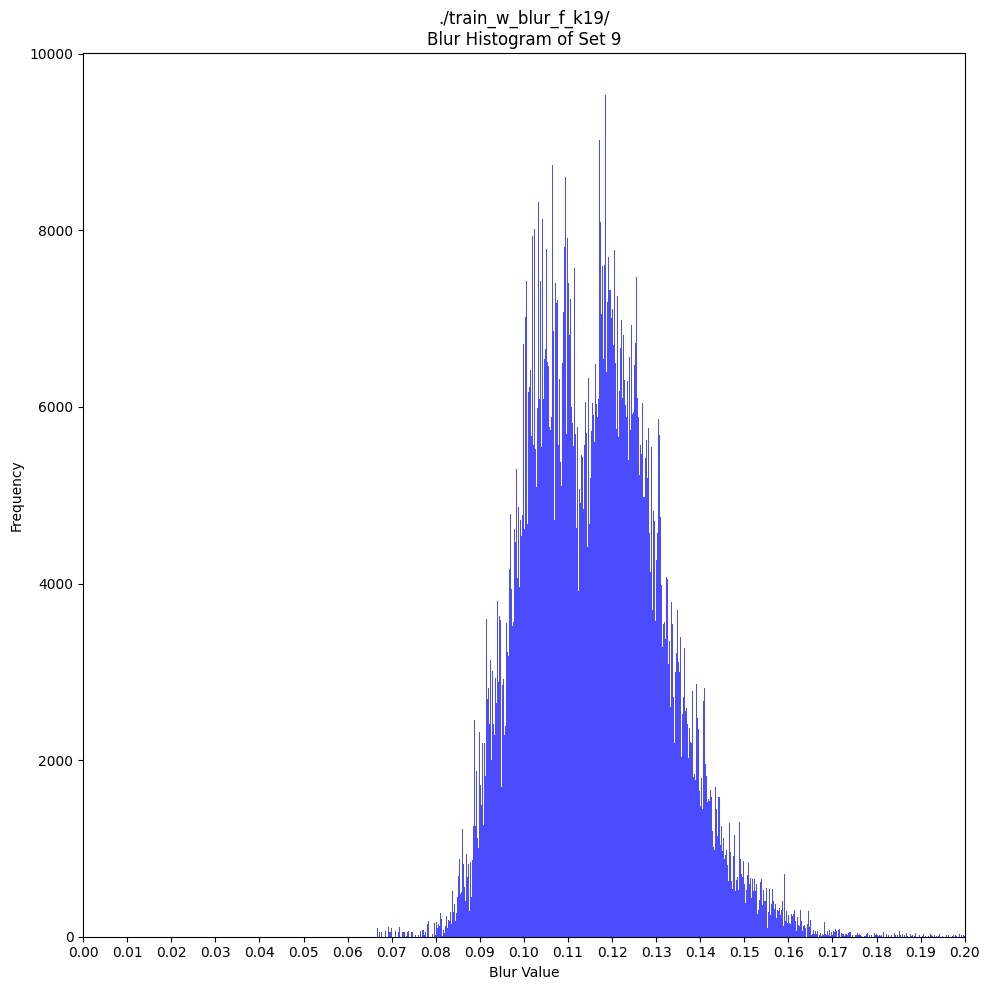

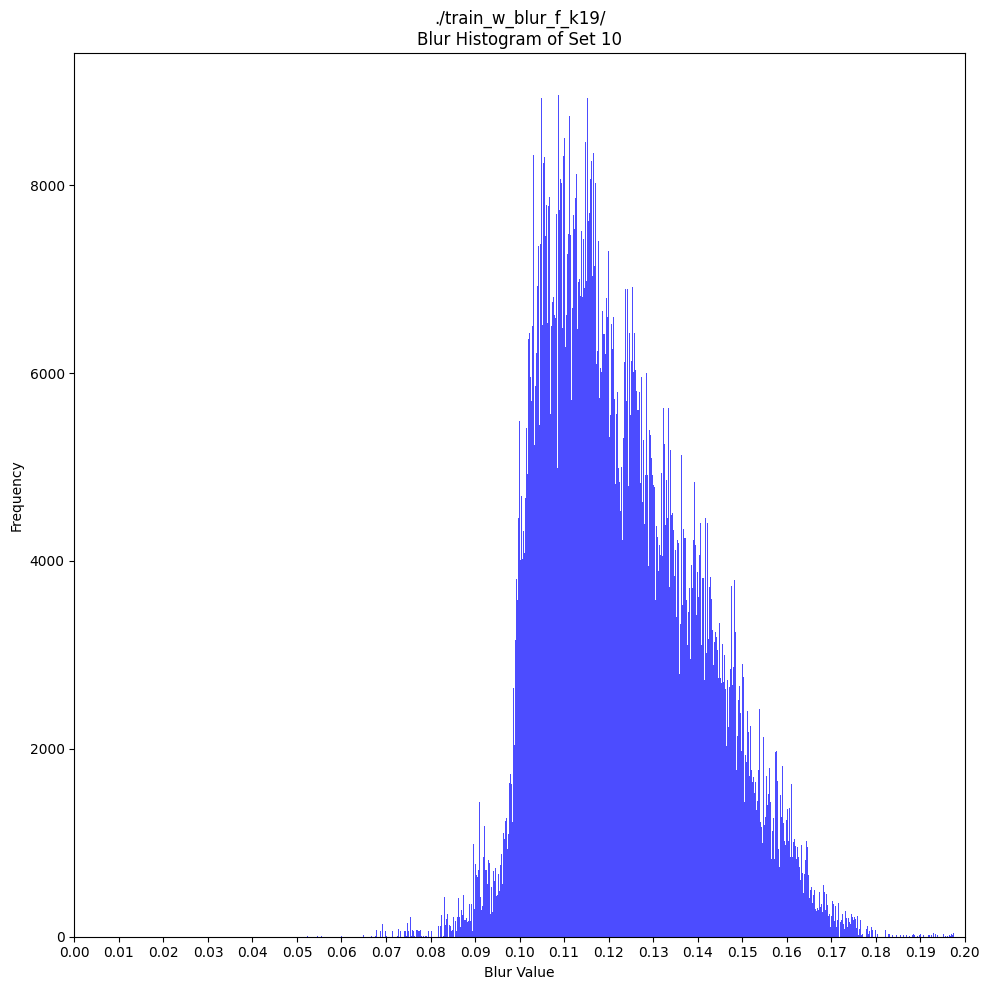

In [51]:
if type(blur) is not np.ndarray:
    
    blur = np.array(blur)
    size_x,size_y = blur.shape[1:3]
    blur = blur.reshape(POSITION_END,TE,size_y,size_x)
    
if type(blur_f) is not np.ndarray:
    blur_f = np.array(blur_f)
    size_x_f,size_y_f = blur_f.shape[1:3]
    blur_f = blur_f.reshape(POSITION_END,TE,size_y_f,size_x_f)

HIST = CAL_HEAD[:-1]+"_hist/"
HIST_F = CAL_HEAD[:-1]+"_hist_f/"
if os.path.isdir(HIST_F) == False:
    os.mkdir(HIST_F)
if os.path.isdir(HIST) == False:
    os.mkdir(HIST)
for i in range(len(blur)):
    datas = []
    datas2 = []
    datas3 = []
    datas_f = []
    for j in range(TE):
        data = blur[i][j].flatten()
        datas.append(data)

        data_f = blur_f[i][j].flatten()
        datas_f.append(data_f)

    datas = np.array(datas)
    datas = datas.flatten()

    # fig,axes = plt.subplots(1,1,figsize=(10,10))
    # axes.hist(datas[~np.isnan(datas)], bins=1000, color='blue', alpha=0.7)
    # axes.set_title(f"{BLUR_STORAGE}\nBlur Histogram of Set {i+1}")
    # axes.set_xlabel("Blur Value")
    # axes.set_ylabel("Frequency")
    # axes.set_xlim(0,0.2)
    # axes.set_xticks(np.arange(0,0.21,0.01))
    # axes.set_ylim(0,1500)

    fig2,axes2 = plt.subplots(1,1,figsize=(10,10))
    datas_f = np.array(datas_f)
    datas_f = datas_f.flatten()
    axes2.hist(datas_f[~np.isnan(datas_f)], bins=1000, color='blue', alpha=0.7)
    axes2.set_title(f"{BLUR_STORAGE_F}\nBlur Histogram of Set {i+1}")
    axes2.set_xlabel("Blur Value")
    axes2.set_ylabel("Frequency")
    axes2.set_xlim(0,0.2)
    axes2.set_xticks(np.arange(0,0.21,0.01))

    plt.tight_layout()
    # plt.show()
    # fig.show()
    fig2.show()
    # fig.savefig(f"{HIST}blur_{i+1}.svg")  
    # fig2.savefig(f"{HIST_F}blur_f_{i+1}.svg")
    # plt.close()   
    

In [9]:
if type(blur) is not np.ndarray:
    
    blur = np.array(blur)
    size_x,size_y = blur.shape[1:3]
    blur = blur.reshape(POSITION_END,TE,size_y,size_x)

if type(blur2) is not np.ndarray:
    blur2 = np.array(blur2)
    size_x,size_y = blur2.shape[1:3]
    blur2 = blur2.reshape(POSITION_END,25,size_y,size_x)


if type(blur3) is not np.ndarray:
    blur3 = np.array(blur3)
    size_x,size_y = blur3.shape[1:3]
    blur3 = blur3.reshape(POSITION_END,25,size_y,size_x)

print("Blur shape : ",blur.shape)
print("Blur2 shape : ",blur2.shape)
print("Blur3 shape : ",blur3.shape)
HIST = CAL_HEAD[:-1]+"_fusion_hist/"
if os.path.isdir(HIST) == False:
    os.mkdir(HIST)
for i in range(len(blur)):
    datas = []
    datas2 = []
    datas3 = []
    for j in range(TE):
        data = blur[i][j].flatten()
        datas.append(data)
        print("One data :",data.shape)
        
    for j in range(25):
        data2 = blur2[i][j].flatten()
        datas2.append(data2)
        print("One data2 :",data2.shape)

        data3 = blur3[i][j].flatten()
        datas3.append(data3)
        print("One data3 :",data3.shape)

    datas = np.array(datas)
    datas = datas.flatten()
    print("After Data : ",datas.shape)
    datas2 = np.array(datas2)
    datas2 = datas2.flatten()
    print("After Data2 : ",datas2.shape)
    datas3 = np.array(datas3)
    datas3 = datas3.flatten()
    print("After Data3 : ",datas3.shape)

    fig,axes = plt.subplots(1,1,figsize=(10,10))
    axes.hist(datas[~np.isnan(datas)], bins=1000, color='blue', alpha=0.7,label="blue obj")
    axes.hist(datas2[~np.isnan(datas2)], bins=1000, color='black', alpha=0.7,label="white obj")
    axes.hist(datas3[~np.isnan(datas3)], bins=1000, color='red', alpha=0.7,label = "orange obj")
    axes.set_title(f"Combination of full size Three obj\nBlur Histogram of Set {i+1}")
    axes.set_xlabel("Blur Value")
    axes.set_ylabel("Frequency")
    axes.set_xlim(0,0.2)
    axes.set_xticks(np.arange(0,0.21,0.01))
    axes.legend()
    # axes.set_ylim(0,1500)

    plt.tight_layout()
    # plt.show()
    fig.savefig(f"{HIST}blur_{i+1}.svg")  
    plt.close()   
    

Blur shape :  (10, 100, 96, 64)
Blur2 shape :  (10, 25, 96, 64)
Blur3 shape :  (10, 25, 96, 64)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : (6144,)
One data : 